In [1]:
# Import libraries
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn.functional as F

# A module to print a model summary (outputs shape, number of parameters, ...)
import torchsummary

# Tensorboard for visualization
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Custom modules and packages
import params.supervised_learning
import utils_supervised
import traversalcost.utils
from dataset import SupervisedNetworkDataset
from model import SupervisedNetwork 
from loss import SupervisedLoss 
from train import train
from validate import validate
from test import test_supervised

## Prepare data

In [2]:
print(params.supervised_learning.DATASET)
print(params.supervised_learning.NB_EPOCHS)
print(params.supervised_learning.BATCH_SIZE)
print(params.supervised_learning.LEARNING_RATE)
print(params.supervised_learning.WEIGHT_DECAY)

help(utils_supervised.compute_traversal_costs)

/home/g_thomas/Documents/PRE/src/traversal_cost/datasets/dataset_supervised
15
1
0.0022
7.41e-07
Help on function compute_traversal_costs in module utils_supervised:

compute_traversal_costs(dataset, cost_function, only_test, to_tensor=False)
    Compute the traversal cost of each sample in a dataset
    
    Args:
        dataset (string): Path to the dataset
        cost_function (function): Function used to compute the cost of a
        sample
        to_tensor (bool, optional): If True, convert the cost to a tensor.
        Defaults to False.
    
    Returns:
        dataframe: A dataframe containing the terrain classes, the linear
        velocities of the robot and the traversal costs



In [4]:
# Create a Dataset for training
train_set = SupervisedNetworkDataset(params.supervised_learning.DATASET / "traversal_costs_train.csv",
                                params.supervised_learning.DATASET / "features")

        
# Create a Dataset for testing
test_set = SupervisedNetworkDataset(params.supervised_learning.DATASET / "traversal_costs_test.csv",
                                params.supervised_learning.DATASET / "features")

In [5]:
# Combine a dataset and a sampler, and provide an iterable over the dataset
# (setting shuffle argument to True calls a RandomSampler, and avoids to
# have to create a Sampler object)

train_loader = DataLoader(
    train_set,
    batch_size= params.supervised_learning.BATCH_SIZE,
    shuffle=True,
    num_workers=12,  # Asynchronous data loading and augmentation
    pin_memory=True,  # Increase the transferring speed of the data to the GPU
)

test_loader = DataLoader(
    test_set,
    batch_size= params.supervised_learning.BATCH_SIZE,
    shuffle=True,
    num_workers=12,  # Asynchronous data loading and augmentation
    pin_memory=True,  # Increase the transferring speed of the data to the GPU
)

## GPU ?

In [6]:
# Use a GPU if available
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

Device: cuda



In [7]:
# Create a model
model = SupervisedNetwork().to(device=device)

criterion = SupervisedLoss().to(device=device)

In [8]:
#Creating list for plot afterwards

List_train_loss_value = []
List_test_loss_value = []

optimizer = optim.SGD(model.parameters(),
                      lr=params.supervised_learning.LEARNING_RATE,
                      momentum=params.supervised_learning.MOMENTUM,
                      weight_decay=params.supervised_learning.WEIGHT_DECAY)

# Loop over the epochs

for epoch in range(params.supervised_learning.NB_EPOCHS):
    
    # Training
    train_loss = train(model,
                       device,
                       train_loader,
                       optimizer,
                       criterion,
                       epoch)
    
    # Validation
    val_loss = validate(model,
                        device,
                        test_loader,
                        criterion,
                        epoch) 
    
    print("Train loss: ", train_loss)
    print("Validation loss: ", val_loss)
    
    # Store the computed losses
    List_train_loss_value.append(train_loss)
    List_test_loss_value.append(val_loss)
    

  0%|          | 0/816 [00:00<?, ?batch/s]

/home/g_thomas/Documents/PRE/src/traversal_cost/supervised_network/loss.py:21: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(estimated_cost, real_cost)


  0%|          | 0/144 [00:00<?, ?batch/s]

Train loss:  57.0586765099536
Validation loss:  57.51194442104962


  0%|          | 0/816 [00:00<?, ?batch/s]

  0%|          | 0/144 [00:00<?, ?batch/s]

Train loss:  57.0586765099536
Validation loss:  57.51194442104962


  0%|          | 0/816 [00:00<?, ?batch/s]

  0%|          | 0/144 [00:00<?, ?batch/s]

Train loss:  57.0586765099536
Validation loss:  57.51194442104962


  0%|          | 0/816 [00:00<?, ?batch/s]

  0%|          | 0/144 [00:00<?, ?batch/s]

Train loss:  57.0586765099536
Validation loss:  57.51194442104962


  0%|          | 0/816 [00:00<?, ?batch/s]

  0%|          | 0/144 [00:00<?, ?batch/s]

Train loss:  57.0586765099536
Validation loss:  57.51194442104962


  0%|          | 0/816 [00:00<?, ?batch/s]

  0%|          | 0/144 [00:00<?, ?batch/s]

Train loss:  57.0586765099536
Validation loss:  57.51194442104962


  0%|          | 0/816 [00:00<?, ?batch/s]

  0%|          | 0/144 [00:00<?, ?batch/s]

Train loss:  57.0586765099536
Validation loss:  57.51194442104962


  0%|          | 0/816 [00:00<?, ?batch/s]

  0%|          | 0/144 [00:00<?, ?batch/s]

Train loss:  57.0586765099536
Validation loss:  57.51194442104962


  0%|          | 0/816 [00:00<?, ?batch/s]

KeyboardInterrupt: 

## Visualization 

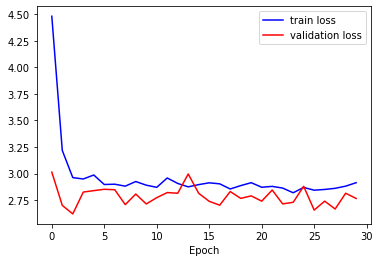

In [8]:
plt.plot(range(params.supervised_learning.NB_EPOCHS), List_train_loss_value, "b", label="train loss")

plt.plot(range(params.supervised_learning.NB_EPOCHS), List_test_loss_value, "r", label="validation loss")

plt.xlabel("Epoch")
plt.legend()

## Testing

In [9]:
# Test the model
test_loss = test_supervised(model,
                 device,
                 test_loader,
                 criterion)

print("Test loss: ", test_loss)

Test loss:  2.658619860187173


In [36]:
def compute_traversal_costs(dataset,
                            cost_function,
                            only_test,
                            to_tensor=False
                            ):
    """Compute the traversal cost of each sample in a dataset

    Args:
        dataset (string): Path to the dataset
        cost_function (function): Function used to compute the cost of a
        sample
        to_tensor (bool, optional): If True, convert the cost to a tensor.
        Defaults to False.

    Returns:
        dataframe: A dataframe containing the terrain classes, the linear
        velocities of the robot and the traversal costs
    """    
    # Read the csv file containing the labels
    
    if only_test == False :
        
        print(f"not only test ok !")

        labels_df = pd.read_csv(dataset + "labels.csv",
                            converters={"id": str})
    
        # Add an empty column to the dataframe
        labels_df["cost"] = ""
    
        for i in range(len(labels_df.index)):
            # Get the id of the current sample
            id = labels_df["id"][i]
            
            # Load the features of the current sample
            features = np.load(dataset + "features/" + str(id) + ".npy")
            
            # Convert the features to a tensor if required
            if to_tensor:
                features = torch.from_numpy(features).float()
            
            # Compute the cost of the current sample
            cost = cost_function(features)
            
            # Convert the cost to a float if required
            if to_tensor:
                cost = cost.item()
            
            # Store the cost in the dataframe
            labels_df.at[i, "cost"] = cost
        
    if only_test == True :
        
        print(f"only test ok !")
        
        labels_df = pd.read_csv(dataset + "labels.csv",
                            converters={"id": str})
        
        test_data_labels_df =  pd.read_csv(dataset + "traversalcosts_test.csv",
                            converters={"id": str})
        
        
        # Add an empty column to the dataframe
        labels_df["cost"] = ""
        
        print(test_data_labels_df)
        
        for i in range(len(test_data_labels_df.index)):
            # Get the id of the current sample
            id = test_data_labels_df["id"][i]
            
            # Load the features of the current sample
            features = np.load(dataset + "features/" + str(id) + ".npy")
            #print(f"feature is {features}")
            
            # Convert the features to a tensor if required
            if to_tensor:
                features = torch.from_numpy(features).float()
            
            # Compute the cost of the current sample
            cost = cost_function(features)
            
            # Convert the cost to a float if required
            if to_tensor:
                cost = cost.item()
            
            # Store the cost in the dataframe
            labels_df.at[i, "predicted_cost"] = cost
        
        labels_df = labels_df.dropna(axis=0)

    # Extract the terrain classes, the linear velocities and the costs
    costs_df = labels_df[["terrain_class",
                          "linear_velocity",
                          "predicted_cost"]]
    
    return costs_df


In [37]:
costs_df = compute_traversal_costs(dataset = params.supervised_learning.DATASET,
                            cost_function=model.to(device="cpu"),
                            only_test = True,
                            to_tensor=True
)

costs_df

only test ok !
96


KeyError: "['terrain_class', 'linear_velocity'] not in index"

In [16]:
def plot_theorical_cost(dictionnary, epoch):
    
    plt.figure(figsize = (20,20))
    t = np.linspace(0, epoch, 500)
    
    for key in dictionnary.keys():
        
        plt.plot(t, dictionnary[key](t), '.', label = f"{key}")
    plt.legend()

In [18]:
# Display the traversal costs
#plt.figure(figsize=(10))


cost_graph = traversalcost.utils.display_traversal_costs(costs_df, False, params.supervised_learning.terrain_cost,
                                                         params.supervised_learning.NB_EPOCHS)
#cost_graph_with_theorical_cost = traversalcost.utils.plot_theorical_cost(params.supervised_learning.terrain_cost, 
#                                                                         params.supervised_learning.NB_EPOCHS)
#cost_graph = traversalcost.utils.display_traversal_costs_whiskers(costs_df)


TypeError: display_traversal_costs() takes 1 positional argument but 4 were given

## Save model parameters

In [ ]:
# Save the model parameters
#torch.save(model.state_dict(), "siamese.params")